# CSC3831 Final Assessment - Part I: Data Engineering



In [1]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted_df = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted_df.drop(["Unnamed: 0"], axis=1, inplace=True)
houses_corrupted_df.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,NaN,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,NaN,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
Dataset Stats


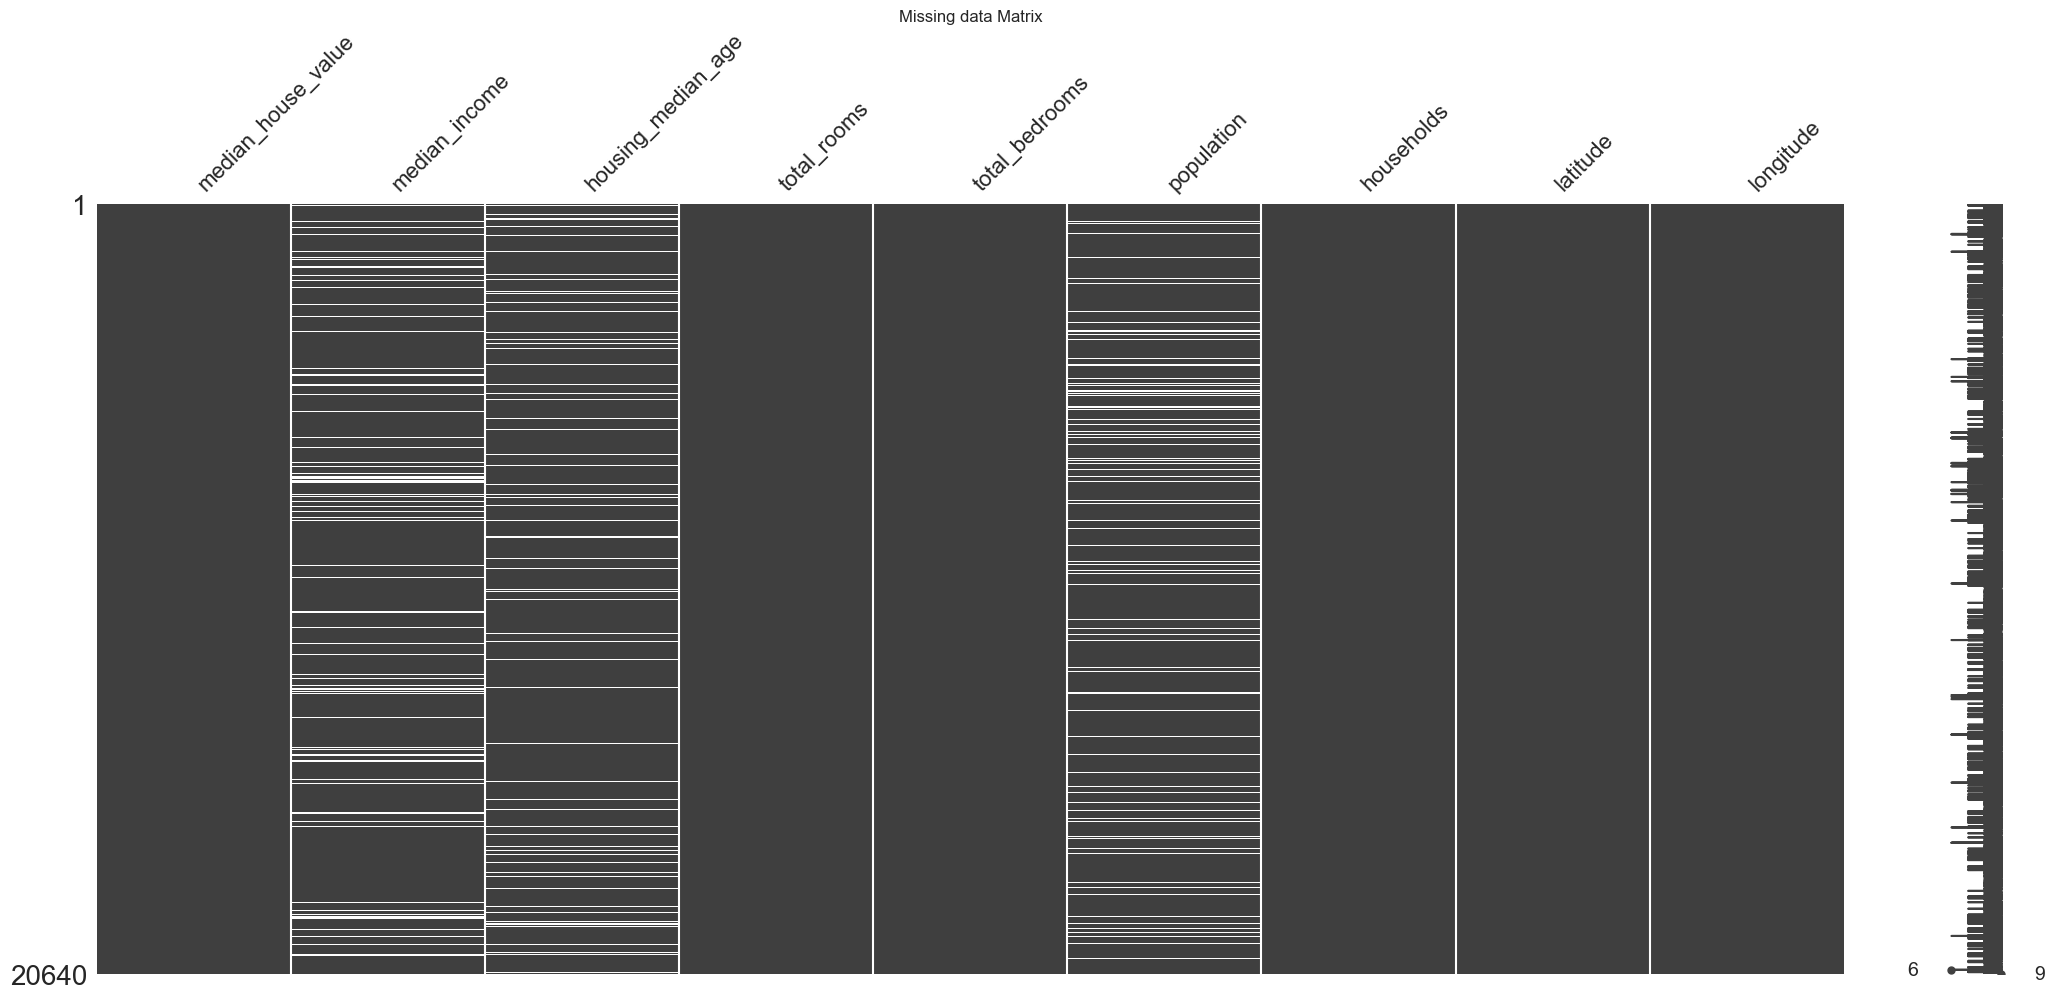

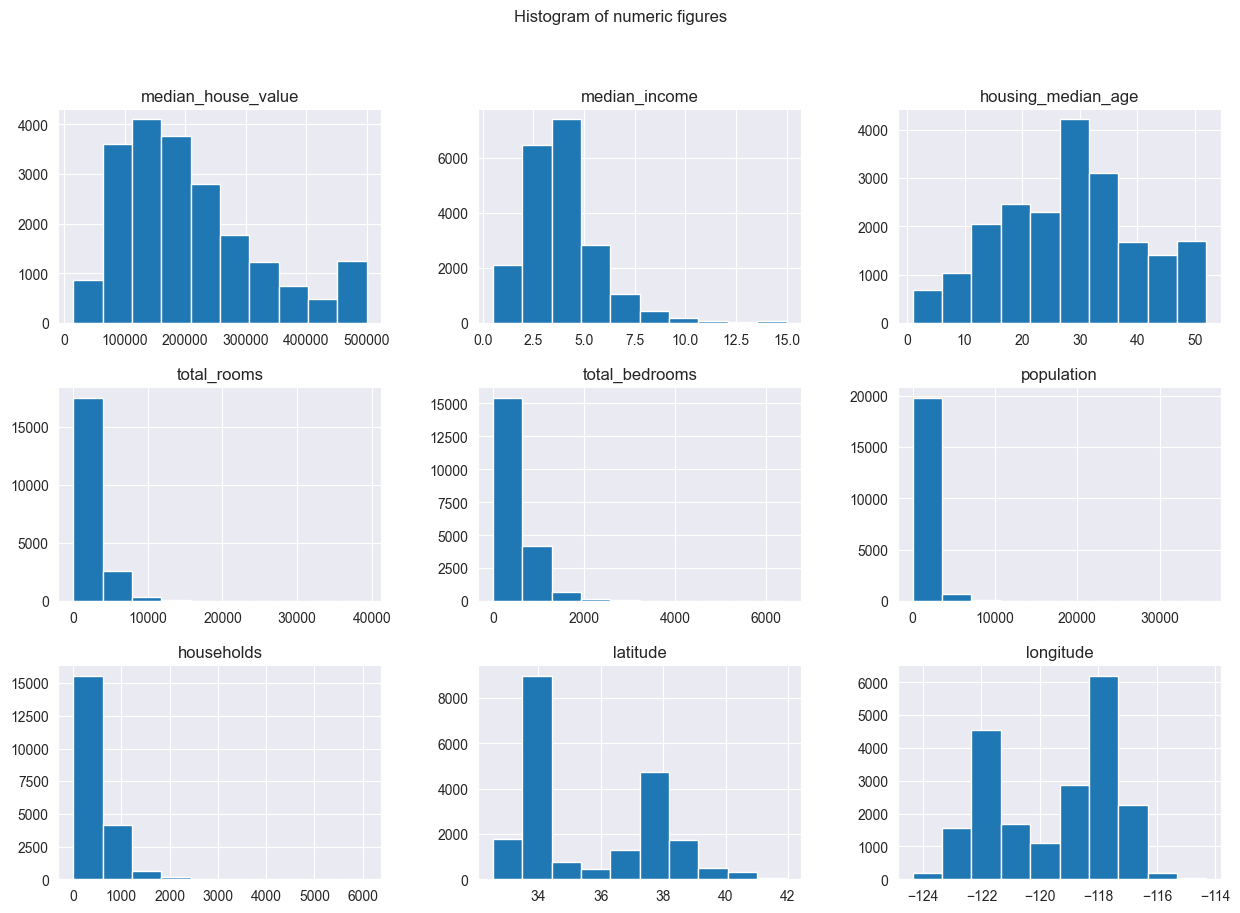

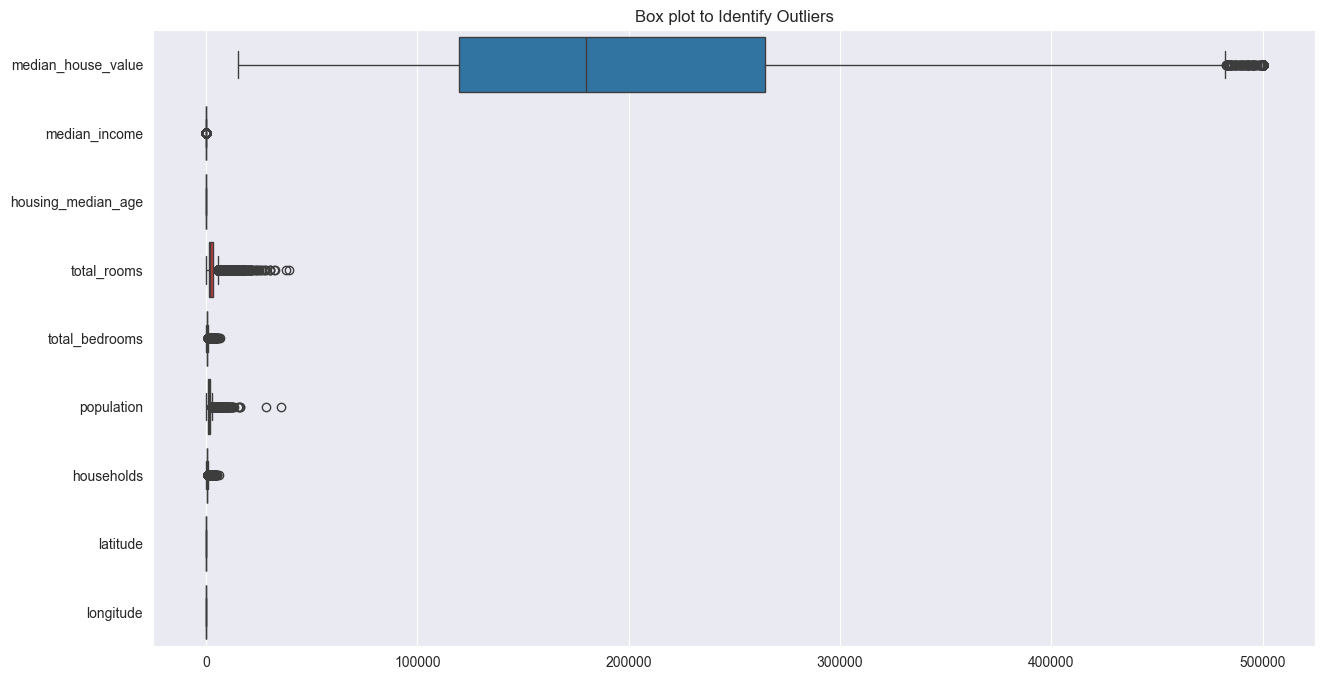

In [2]:
#Basic info
print("Dataset information")
houses_corrupted_df.info()
print ('Dataset Stats')
houses_corrupted_df.describe()
#missing data
msno.matrix(houses_corrupted_df)
plt.title('Missing data Matrix')
plt.show

# Imputing missing values using median
imputer = SimpleImputer(strategy="median")
houses_imputed = pd.DataFrame(imputer.fit_transform(houses_corrupted_df),columns=houses_corrupted_df.columns)

#Distribution of numeric figures
houses_imputed.hist(figsize=(15,10))
plt.suptitle("Histogram of numeric figures")
plt.show

# Box plots to Identify Outliers
plt.figure(figsize=(15,8))
sns.boxplot(data=houses_imputed, orient='h')
plt.title("Box plot to Identify Outliers")
plt.show()


### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


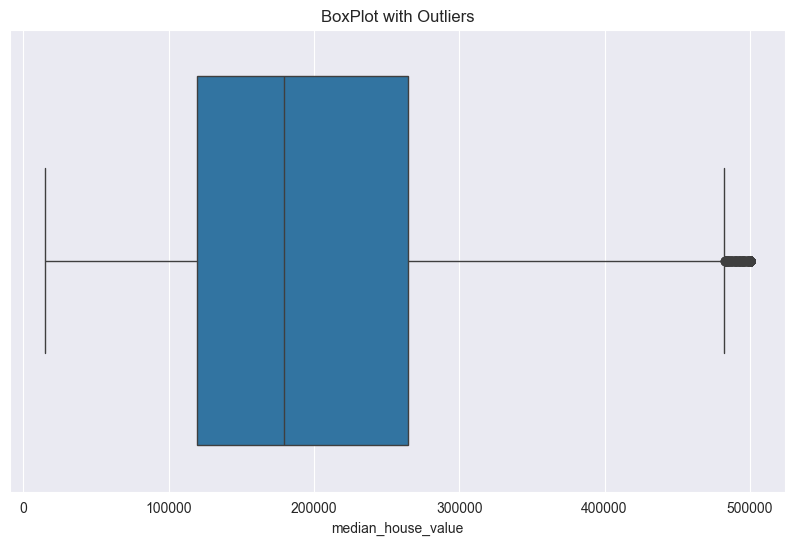

In [3]:
# Using IQR for statistical Outlier Detection
def detect_outliers_iqr(data):
    outliers = {}
    for column in data.select_dtypes(include=np.number).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1-1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
        return outliers

iqr_outliers = detect_outliers_iqr(houses_imputed)

#Visualize IQR Outliers
plt.figure(figsize=(10,6))
for col, outlier_data in iqr_outliers.items():
    sns.boxplot(data=houses_imputed, x=col)
    plt.title(f"BoxPlot with Outliers")
    plt.show()


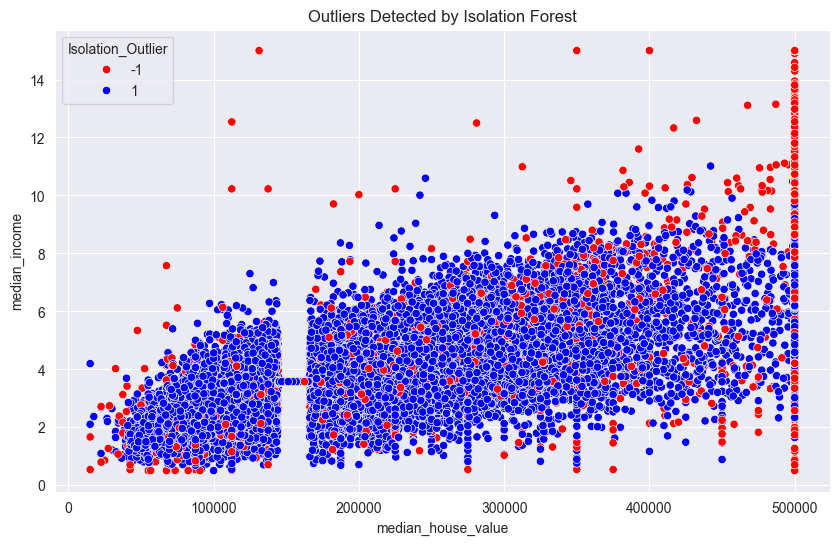

In [4]:
# Algorithmic Outlier Detection using Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_outliers = isolation_forest.fit_predict(houses_imputed.select_dtypes(include=np.number))
houses_imputed['Isolation_Outlier'] = isolation_outliers

# Visualizing Algorithmic Outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=houses_imputed, x=houses_imputed.select_dtypes(include=np.number).columns[0],
                y=houses_imputed.select_dtypes(include=np.number).columns[1],
                hue='Isolation_Outlier', palette={1: 'blue', -1: 'red'})
plt.title("Outliers Detected by Isolation Forest")
plt.show()


### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


Columns to Impute: ['median_house_value', 'median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']
Columns to Remove: []


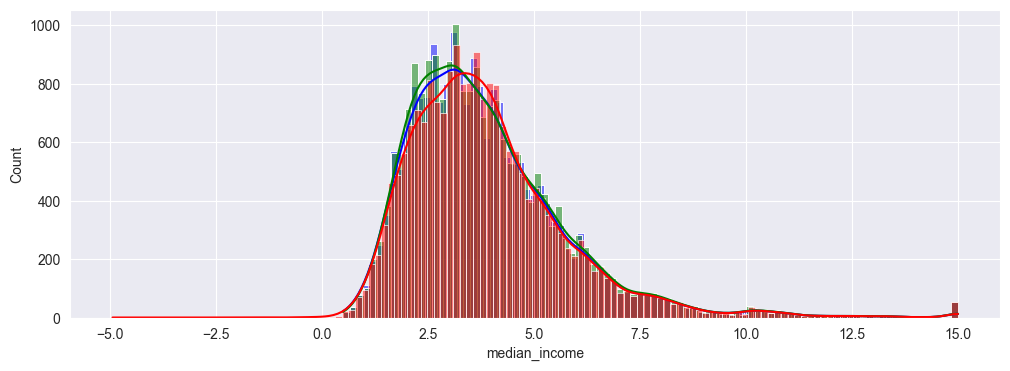

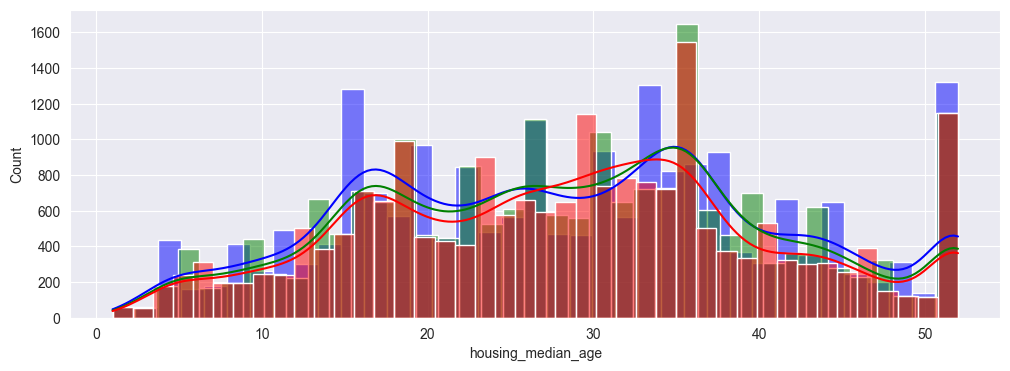

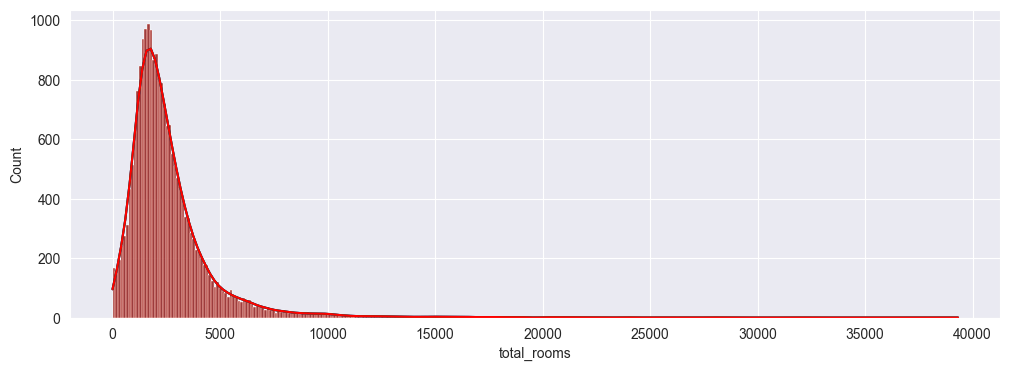

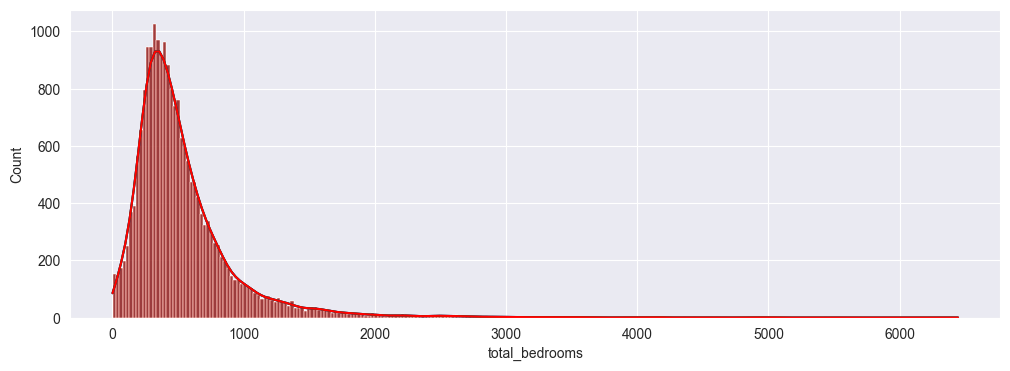

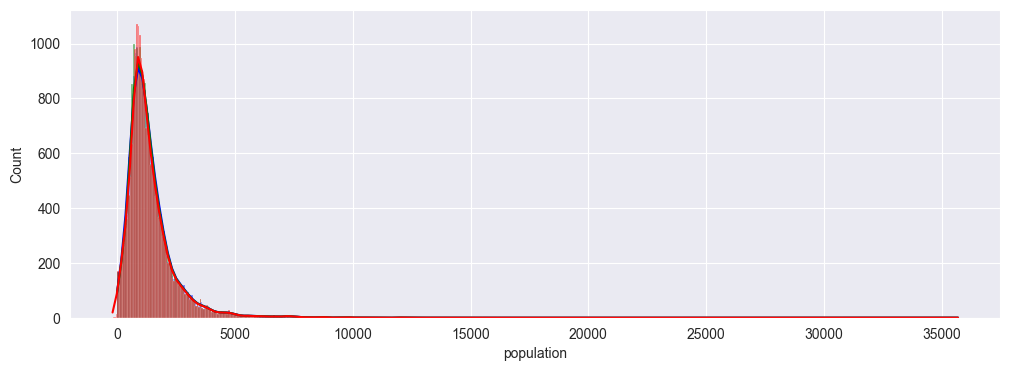

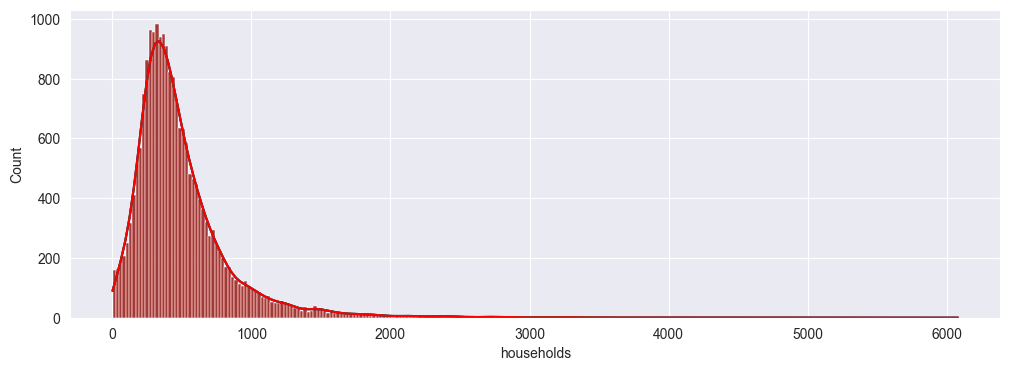

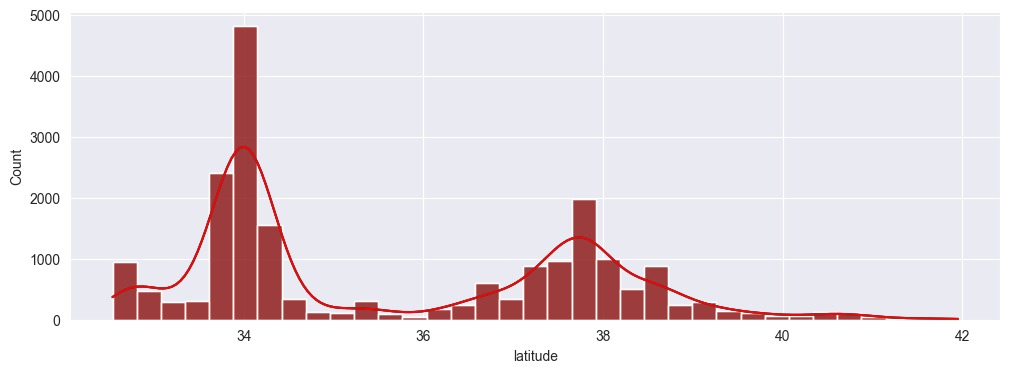

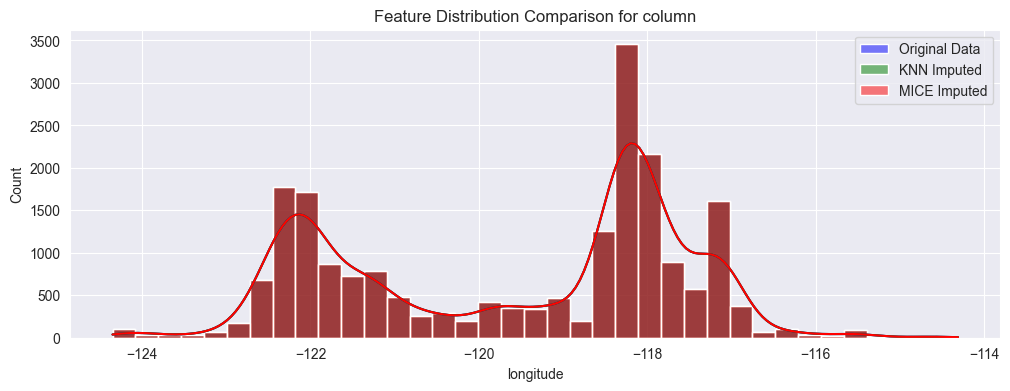

In [6]:
# Use this dataset for comparison against the imputed datasets
original_houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

#houses_corrupted_df.drop(["Unnamed:0"], axis=1, inplace=True)

#Determining features to impute or remove in corrupted dataset.
missing_data = houses_corrupted_df.isnull().mean()
impute_columns = missing_data[missing_data < 0.3].index.tolist()  # Impute if less than 30% missing
remove_columns = missing_data[missing_data >= 0.3].index.tolist()

print('Columns to Impute:', impute_columns)
print('Columns to Remove:', remove_columns)

#Drop columns with excessive missing values
houses_corrupted_df.drop(columns=remove_columns, inplace=True)
#Seperate Target Variables
target = 'median_house_value'
X_non_imputed = houses_corrupted_df.drop(columns=[target])
y= houses_corrupted_df[target].dropna()

# Performing KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_non_imputed), columns=X_non_imputed.columns)

# Performing MICE Imputation
mice_imputer = IterativeImputer(random_state=42)
X_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(X_non_imputed), columns=X_non_imputed.columns)

#Evaluatiing a distribution comparison with Original Datatset

for column in X_non_imputed.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(original_houses[column], color='blue', label='Original Data', kde=True)
    sns.histplot(X_knn_imputed[column], color='green', label="KNN Imputed", kde=True)
    sns.histplot(X_mice_imputed[column], color='red', label="MICE Imputed", kde=True)
plt.title(f"Feature Distribution Comparison for column")
plt.legend()
plt.show()


### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation